$$
\newcommand{\Exp}{\operatorname{Exp}}
\newcommand{\Binomial}{\operatorname{Binomial}}
\newcommand{\Poisson}{\operatorname{Poisson}}
\newcommand{\BB}{\mathbb{B}}
\newcommand{\EE}{\mathbb{E}}
\newcommand{\PP}{\mathbb{P}}
\newcommand{\RR}{\mathbb{R}}
\newcommand{\NN}{\mathbb{N}}
\newcommand{\ZZ}{\mathbb{Z}}
\newcommand{\dD}{\mathcal{D}}
\newcommand{\fF}{\mathcal{F}}
\newcommand{\lL}{\mathcal{L}}
\newcommand{\linop}{\mathcal{L}(\mathbb{B})}
\newcommand{\linopell}{\mathcal{L}(\ell_1)}
$$

# The Markov Property

In addition to what’s in Anaconda, this lecture will need the following libraries:

In [ ]:
!pip install quantecon

## Overview

A continuous time stochastic process is said to have the Markov property if
its past and future are independent given the current state.

(A more formal definition is provided below.)

As we will see, the Markov property imposes a large amount of structure on
continuous time processes.

This structure leads to elegant and powerful results on
evolution and dynamics.

At the same time, the Markov property is general enough to cover many applied
problems, as described in [the introduction](https://continuous-time-mcs.quantecon.org/intro.html).

### Setting

In this lecture, the state space where dynamics
evolve will be a [countable set](https://en.wikipedia.org/wiki/Countable_set),
denoted henceforth by $ S $, with typical elements $ x, y $.

(Note that “countable” is understood to include finite.)

Regarding notation, in what follows, $ \sum_{x \in S} $ is abbreviated to
$ \sum_x $, the supremum $ \sup_{x \in S} $ is abbreviated to $ \sup_x $ and so on.

A **distribution** on $ S $ is a function $ \phi $ from $ S $ to $ \RR_+ $ with
$ \sum_x \phi(x) = 1 $.

Let $ \dD $ denote the set of all distributions on $ S $.

To economize on terminology, we define a **matrix** $ A $ on $ S $ to be a map
from $ S \times S $ to $ \RR $.

When $ S $ is finite, this reduces to the usual notion of a matrix, and,
whenever you see expressions such as $ A(x,y) $ below, you can
mentally identify them with more familiar matrix
notation, such as $ A_{ij} $, if you wish.

The product of two matrices $ A $ and $ B $ is defined by


<a id='equation-kernprod'></a>
$$
(A B)(x, y) = \sum_z A(x, z) B(z, y)
    \qquad ((x, y) \in S \times S) \tag{3.1}
$$

If $ S $ is finite, then this is just ordinary matrix multiplication.

In statements involving matrix algebra, we *always treat distributions as row
vectors*, so that, for $ \phi \in \dD $ and given matrix $ A $,

$$
(\phi A)(y) = \sum_x \phi(x) A(x, y)
$$

We will use the following imports

In [ ]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

import quantecon as qe
from numba import njit

from scipy.linalg import expm
from scipy.stats import binom

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

## Markov Processes

We now introduce the definition of Markov processes, first reviewing the
discrete case and then shifting to continuous time.


<a id='finstatediscretemc'></a>

### Discrete Time, Finite State

The simplest Markov processes are those with a discrete time parameter and finite state space.

Assume for now that $ S $ has $ n $ elements and let $ P $ be a **Markov matrix**,
which means that $ P(x,y) \geq 0 $ and $ \sum_y P(x,y) = 1 $ for all $ x $.

In applications, $ P(x, y) $ represents the probability of transitioning from $ x $ to
$ y $ in one step.

A **Markov chain** $ (X_t)_{t \in \ZZ_+} $ on $ S $ with Markov
matrix $ P $ is a sequence of random variables satisfying


<a id='equation-markovpropd'></a>
$$
\PP\{X_{t+1} = y \,|\, X_0, X_1, \ldots, X_t \} = P (X_t, y) \tag{3.2}
$$

with probability one for all $ y \in S $ and any $ t \in \ZZ_+ $.

In addition to connecting probabilities to the Markov matrix,
[(3.2)](#equation-markovpropd) says that the process depends on its history only through
the current state.

We [recall that](https://python.quantecon.org/finite_markov.html#marginal-distributions), if $ X_t $
has distribution $ \phi $, then $ X_{t+1} $ has distribution $ \phi P $.

Since $ \phi $ is understood as a row vector, the meaning is


<a id='equation-update-rule'></a>
$$
(\phi P)(y) = \sum_x \phi(x) P(x, y) 
    \qquad (y \in S) \tag{3.3}
$$


<a id='jdfin'></a>

#### The Joint Distribution

In general, for given Markov matrix $ P $, there can be many Markov chains
$ (X_t) $ that satisfy [(3.2)](#equation-markovpropd).

This is due to the more general observation that, for a given distribution
$ \phi $, we can construct many random variables having distribution $ \phi $.

(The exercises below ask for one example.)

Hence $ P $ is, in a sense, a more primitive object than $ (X_t) $.

There is another way to see the fundamental importance of $ P $, which is by
constructing the joint distribution of $ (X_t) $ from $ P $.

Let $ S^\infty $ represent the space of $ S $-valued sequences $ (x_0, x_1, x_2, \ldots) $.

Fix an initial condition $ \psi \in \dD $ and a Markov matrix $ P $ on $ S $.

The **joint distribution** of a Markov chain $ (X_t) $ satisfying
[(3.2)](#equation-markovpropd) and $ X_0 \sim \psi $ is the distribution $ \mathbf P_\psi $ over
$ S^\infty $ such that


<a id='equation-jointdeq'></a>
$$
\PP\{ X_{t_1} = y_1, \ldots, X_{t_m} = y_m \}
    =
    \mathbf P_\psi\{ (x_t) \in S^\infty \,:\, 
        x_{t_i} = y_i \text{ for } i = 1, \ldots m\} \tag{3.4}
$$

for any $ m $ positive integers $ t_i $ and $ m $ elements  $ y_i $ of the state space $ S $.

(Joint distributions of discrete time processes are uniquely defined by their
values at finite collections of times — see, for example, Theorem 7.2 of [[Walsh, 2012](https://continuous-time-mcs.quantecon.org/zreferences.html#id10)].)

We can construct $ \mathbf P_\psi $ by first defining $ P_\psi^n $ over
the finite Cartesian product $ S^{n+1} $ via


<a id='equation-mathjointd'></a>
$$
\mathbf P_\psi^n(x_0, x_1, \ldots, x_n)
        = \psi(x_0)
        P(x_0, x_1)
        \times \cdots \times
        P(x_{n-1}, x_n) \tag{3.5}
$$

For any Markov chain $ (X_t) $ satisfying [(3.2)](#equation-markovpropd) and $ X_0 \sim \psi $,
the restriction $ (X_0, \ldots, X_n) $ has joint distribution $ \mathbf
P_\psi^n $.

This is a solved exercise below.

The last step is to show that the family $ (\mathbf P_\psi^n) $ defined at each
$ n \in \NN $ extends uniquely to a distribution $ \mathbf P_\psi $ over the
infinite sequences in $ S^\infty $.

That this is true follows from a well known [theorem of Kolmogorov](https://en.wikipedia.org/wiki/Kolmogorov_extension_theorem).

Hence $ P $ defines the joint distribution $ \mathbf P_\psi $ when paired with any initial condition $ \psi $.

### Extending to Infinite (Countable) State Spaces

When $ S $ is infinite, the same idea carries through.

Consistent with the finite case, a **Markov matrix** is a map
$ P $ from $ S \times S $ to $ \RR_+ $ satisfying

$$
\sum_y P(x, y) = 1 
    \text{ for all } x \in S
$$

The definition of a Markov chain $ (X_t)_{t \in \ZZ_+} $ on $ S $ with Markov matrix  $ P $ is exactly as in [(3.2)](#equation-markovpropd).

Given Markov matrix $ P $ and $ \phi \in \dD $, we define $ \phi P $ by
[(3.3)](#equation-update-rule).

Then, as before, $ \phi P $ can be understood as the distribution of
$ X_{t+1} $ when $ X_t $ has distribution $ \phi $.

The function $ \phi P $ is in $ \dD $, since, by [(3.3)](#equation-update-rule), it is
nonnegative and

$$
\sum_y (\phi P)(y) 
    = \sum_y \sum_x P(x, y) \phi(x)
    = \sum_x \sum_y P(x, y) \phi(x)
    = \sum_x \phi(x)
    = 1
$$

(Swapping the order of infinite sums is justified here by the fact that all
elements are nonnegative — a version of Tonelli’s theorem).

If $ P $ and $ Q $ are Markov matrices on $ S $, then, using the definition in
[(3.1)](#equation-kernprod),

$$
(P Q)(x, y) := \sum_z P(x, z) Q(z, y)
$$

It is not difficult to check that $ P Q $ is again a Markov matrix on $ S $.

The elements of $ P^k $, the $ k $-th product of $ P $ with itself, give $ k $ step transition probabilities.

For example, we have


<a id='equation-kernprodk'></a>
$$
P^k(x, y) 
    = (P^{k-j} P^j)(x, y) = \sum_z P^{k-j}(x, z) P^j(z, y) \tag{3.6}
$$

which is a version of the (discrete time) Chapman-Kolmogorov equation.

Equation [(3.6)](#equation-kernprodk) can be obtained from the law of total probability: if
$ (X_t) $ is a Markov chain with Markov matrix $ P $ and initial condition $ X_0 =
x $, then

$$
\PP\{X_k = y\}
    = \sum_z \PP\{X_k = y \,|\, X_j=z\} \PP\{X_j=z\}
$$

All of the [preceding discussion](#jdfin) on the connection between $ P $
and the joint distribution of $ (X_t) $ when $ S $ is finite carries over
to the current setting.

### The Continuous Time Case

A **continuous time stochastic process** on $ S $ is a collection $ (X_t) $ of $ S $-valued
random variables $ X_t $ defined on a common probability space and indexed by $ t
\in \RR_+ $.

Let $ I $ be the Markov matrix on $ S $ defined by $ I(x,y) = \mathbb 1\{x = y\} $.

A **Markov semigroup** is a family $ (P_t) $ of Markov matrices
on $ S $ satisfying

1. $ P_0 = I $,  
1. $ \lim_{t \to 0} P_t(x, y) = I(x,y) $ for all $ x,y $ in $ S $, and  
1. the semigroup property $ P_{s + t} = P_s P_t $ for all $ s, t \geq 0 $.  


The interpretation of $ P_t(x, y) $ is the probability of moving from state $ x $
to state $ y $ in $ t $ units of time.

As such it is natural that $ P_0(x,y) = 1 $ if $ x=y $ and zero otherwise, which
is condition 1.

Condition 2 is continuity with respect to $ t $, which might seem restrictive
but it is in fact very mild.

For all practical applications, probabilities do not jump — although the
chain $ (X_t) $ itself can of course jump from state to state as time
goes by.<sup><a href=#footnote1 id=footnote1-link>[1]</a></sup>

The semigroup property in condition 3 is nothing more than a continuous
time version of the Chapman-Kolmogorov equation.

This becomes clearer if we write it more explicitly as


<a id='equation-chapkol-ct2'></a>
$$
P_{s+t}(x, y) 
    = \sum_z P_s(x, z) P_t(z, y) \tag{3.7}
$$

A stochastic process $ (X_t) $ is called a (time homogeneous) **continuous time
Markov chain** on $ S $ with Markov semigroup $ (P_t) $ if


<a id='equation-markovprop'></a>
$$
\PP\{X_{s + t} = y \,|\, \fF_s \}
    = P_t (X_s, y) \tag{3.8}
$$

with probability one for all $ y \in S $ and $ s, t \geq 0 $.

Here $ \fF_s $ is the history $ (X_r)_{r \leq s} $ of the process up until
time $ s $.

If you are an economist you might call $ \fF_s $ the “information set” at time
$ s $.

If you are familiar with measure theory, you can understand $ \fF_s $ as
the $ \sigma $-algebra generated by $ (X_r)_{r \leq s} $.

Analogous to the discrete time case, the joint
distribution of $ (X_t) $ is determined by its Markov semigroup plus an
initial condition.

This distribution is defined over the set of all right continuous functions
$ \RR_+ \ni t \mapsto x_t \in S $, which we call $ rcS $.

Next one builds [finite dimensional distributions](https://en.wikipedia.org/wiki/Finite-dimensional_distribution) over $ rcS $ using
expressions similar to [(3.5)](#equation-mathjointd).

Finally, the Kolmogorov extension theorem is applied, similar to the discrete
time case.

Corollary 6.4 of [[Le Gall, 2016](https://continuous-time-mcs.quantecon.org/zreferences.html#id9)] provides full details.

### The Canonical Chain

Given a Markov semigroup $ (P_t) $ on $ S $, does there always exist a continuous
time Markov chain $ (X_t) $ such that [(3.8)](#equation-markovprop) holds?

The answer is affirmative.

To illustrate, pick any Markov semigroup $ (P_t) $ on $ S $ and fix initial
condition $ \psi $.

Next, create the corresponding joint distribution $ \mathbf P_\psi $ over
$ rcS $, as described above.

Now, for each $ t \geq 0 $, let $ \pi_t $ be the time $ t $ projection on
$ rcS $, which maps any right continuous function $ (x_\tau) $ into its time $ t $ value
$ x_t $.

Finally, let $ X_t $ be an $ S $-valued function on $ rcS $ defined at $ (x_\tau) \in rcS $ by $ \pi_t ( (x_\tau)) $.

In other words, after $ \mathbf P_\psi $ picks out some time path $ (x_\tau) \in
rcS $, the Markov chain $ (X_t) $ simply reports this time path.

Hence $ (X_t) $ automatically has the correct distribution.

The chain $ (X_t) $ constructed in this way is called the **canonical chain**
for the semigroup $ (P_t) $ and initial condition $ \psi $.

### Simulation and Probabilistic Constructions

While we have answered the existence question in the affirmative,
the canonical construction is quite abstract.

Moreover, there is little information about how we might simulate such a chain.

Fortunately, it turns out that there are more concrete ways to build
continuous time Markov chains from the objects that describe their
distributions.

We will learn about these in a [later lecture](https://continuous-time-mcs.quantecon.org/uc_mc_semigroups.html).

## Implications of the Markov Property

The Markov property carries some strong implications that are not immediately
obvious.

Let’s take some time to explore them.

### Example: Failure of the Markov Property

Let’s look at how the Markov property can fail, via an intuitive rather than
formal discussion.

Let $ (X_t) $ be a continuous time stochastic process with state space $ S = \{0, 1\} $.

The process starts at $ 0 $ and updates at follows:

1. Draw $ W $ independently from a fixed Pareto distribution.  
1. Hold $ (X_t) $ in its current state for $ W $ units of time and then switch
  to the other state.  
1. Go to step 1.  


What is the probability that $ X_{s+h} = i $ given both the history $ (X_r)_{r \leq s} $ and current information $ X_s = i $?

If $ h $ is small, then this is close to the
probability that there are zero switches over the time interval $ (s, s+h] $.

To calculate this probability, it would be helpful to know how long the
state has been at current state $ i $.

This is because the Pareto distribution [is not memoryless](https://continuous-time-mcs.quantecon.org/memoryless.html#fail-mem).

(With a Pareto distribution, if we know that $ X_t $ has been at $ i $ for a long
time, then a switch in the near future becomes more likely.)

As a result, the history prior to $ X_s $ is useful for predicting $ X_{s+h} $,
even when we know $ X_s $.

Thus, the Markov property fails.

### Restrictions Imposed by the Markov Property

From the discussion above, we see that, for continuous time Markov chains,
the length of time between jumps must be memoryless.

Recall that, by [Theorem 1.1](https://continuous-time-mcs.quantecon.org/memoryless.html#exp_unique), the only memoryless
distribution supported on $ \RR_+ $ is the exponential distribution.

Hence, a continuous time Markov chain waits at states for an
exponential amount of time and then jumps.

The way that the new state is chosen must also satisfy the Markov property,
which adds another restriction.

In summary, we already understand the following about continuous time Markov chains:

1. Holding times are independent exponential draws.  
1. New states are chosen in a ``Markovian’’ way, independent of the past given the current state.  


We just need to clarify the details in these steps to have a complete description.

## Examples of Markov Processes

Let’s look at some examples of processes that possess the Markov property.

### Example: Poisson Processes

The Poisson process discussed in our [previous lecture](https://continuous-time-mcs.quantecon.org/poisson.html) is a
Markov process on state space $ \ZZ_+ $.

To obtain the Markov semigroup, we observe that, for $ k \geq j $,

$$
\PP\{N_{s + t} = k \,|\, N_s = j\}
    = \PP\{N_{s + t} - N_s = k - j \,|\, N_s = j\}
    = \PP\{N_{s + t} - N_s = k - j\}
$$

where the last step is due to independence of increments.

From stationarity of increments we have

$$
\PP\{N_{s + t} - N_s = k - j\}
    = \PP\{N_t = k - j\}
    = e^{-\lambda t} \frac{ (\lambda t)^{k-j} }{(k-j)!}
$$

In summary, the Markov semigroup is


<a id='equation-poissemi'></a>
$$
P_t(j, k) 
    = e^{-\lambda t} \frac{ (\lambda t)^{k-j} }{(k-j)!} \tag{3.9}
$$

whenever $ j \leq k $ and $ P_t(j, k) = 0 $ otherwise.

This chain of equalities was obtained with $ N_s = j $ for arbitrary $ j $, so we
can replace $ j $ with $ N_s $ in [(3.9)](#equation-poissemi) to verify the Markov property [(3.8)](#equation-markovprop) for the Poisson process.

Under [(3.9)](#equation-poissemi), each $ P_t $ is a Markov matrix and $ (P_t) $ is a
Markov semigroup.

The proof of the semigroup property is a solved exercise below.<sup><a href=#footnote2 id=footnote2-link>[2]</a></sup>


<a id='inventory-dynam'></a>

## A Model of Inventory Dynamics

Let $ X_t $ be the inventory of a firm at time $ t $, taking values in the
integers $ 0, 1, \ldots, b $.

If $ X_t > 0 $, then a customer arrives after $ W $
units of time, where $ W \sim \Exp (\lambda) $ for some fixed $ \lambda > 0 $.

Upon arrival, each customer purchases $ \min\{U, X_t\} $ units, where $ U $ is an
IID draw from the geometric distribution started at 1 rather than 0:

$$
\PP\{U = k\} = (1-\alpha)^{k-1} \alpha
    \qquad (k = 1, 2, \ldots, \; \alpha \in (0, 1))
$$

If $ X_t = 0 $, then no customers arrive and the firm places an order for $ b $ units.

The order arrives after a delay of $ D $ units of time, where $ D \sim \Exp (\lambda) $.

(We use the same $ \lambda $ here just for convenience, to simplify the exposition.)

### Representation

The inventory process jumps to a new value either when a new customer arrives
or when new stock arrives.

Between these arrival times it is constant.

Hence, to track $ X_t $, it is enough to track the jump times and the new values
taken at the jumps.

In what follows, we denote the jump times by $ \{J_k\} $ and the values at jumps
by $ \{Y_k\} $.

Then we construct the state process via


<a id='equation-xfromy'></a>
$$
X_t = \sum_{k \geq 0} Y_k \mathbb 1\{J_k \leq t < J_{k+1}\}
    \qquad (t \geq 0) \tag{3.10}
$$

### Simulation

Let’s simulate this process, starting at $ X_0 = 0 $.

As above,

- $ J_k $ is the time of the $ k $-th jump (up or down) in inventory.  
- $ Y_k $ is the size of the inventory after the $ k $-th jump.  
- $ (X_t) $ is defined from these objects via [(3.10)](#equation-xfromy).  


Here’s a function that generates and returns one path $ t \mapsto X_t $.

(We are not aiming for computational efficiency at this stage.)

In [ ]:
def sim_path(T=10, seed=123, λ=0.5, α=0.7, b=10):
    """
    Generate a path for inventory starting at b, up to time T.

    Return the path as a function X(t) constructed from (J_k) and (Y_k).
    """

    J, Y = 0, b
    J_vals, Y_vals = [J], [Y]
    np.random.seed(seed)

    while True:
        W = np.random.exponential(scale=1/λ)  # W ~ Exp(λ)
        J += W
        J_vals.append(J)
        if J >= T:
            break
        # Update Y
        if Y == 0:
            Y = b
        else:
            U = np.random.geometric(α)
            Y = Y - min(Y, U)
        Y_vals.append(Y)
    
    Y_vals = np.array(Y_vals)
    J_vals = np.array(J_vals)

    def X(t):
        if t == 0.0:
            return Y_vals[0]
        else:
            k = np.searchsorted(J_vals, t)
            return Y_vals[k-1]

    return X

Let’s plot the process $ (X_t) $.

In [ ]:
T = 20
X = sim_path(T=T)

grid = np.linspace(0, T, 100)

fig, ax = plt.subplots()
ax.step(grid, [X(t) for t in grid], label="$X_t$")

ax.set(xlabel="time", ylabel="inventory")

ax.legend()
plt.show()

As expected, inventory falls and then jumps back up to $ b $.

### The Embedded Jump Chain

In models such as the one described above, the embedded discrete time
process $ (Y_k) $ is called the “embedded jump chain”.

It is easy to see that $ (Y_k) $ is discrete time finite state Markov chain.

Its Markov matrix $ K $ is
given by  $ K(x, y) = \mathbb 1\{y=b\} $ when $ x=0 $ and,  when $ 0 < x \leq b $,


<a id='equation-ijumpkern'></a>
$$
K(x, y)
    =
    \begin{cases}
    \mathbb 0 & \text{ if }  y \geq x
    \\
    \PP\{x - U = y\} = (1-\alpha)^{x-y-1} \alpha 
        & \text{ if } 0 < y < x
    \\
    \PP\{U \geq x\} = (1-\alpha)^{x-1}
        & \text{ if } y = 0
    \end{cases} \tag{3.11}
$$

### Markov Property

The inventory model just described has the Markov property precisely because

1. the jump chain $ (Y_k) $ is Markov in discrete time and  
1. the holding times are independent exponential draws.  


Rather than providing more details on these points here, let us first describe
a more general setting where the arguments will be clearer and more useful.

## Jump Processes with Constant Rates

The examples we have focused on so far are special cases of Markov processes
with constant jump intensities.

These processes turn out to be very representative (although the constant jump intensity will later be relaxed).

Let’s now summarize the model and its properties.

### Construction

The data for a Markov process on $ S $ with constant jump rates are

- a parameter $ \lambda > 0 $ called the **jump rate**, which governs the jump
  intensities and  
- a Markov matrix $ K $ on $ S $, called the **jump matrix**.  


To run the process we also need an initial condition $ \psi \in \dD $.

The process $ (X_t) $ is constructed by holding at each state for an
exponential amount of time, with rate $ \lambda $, and then updating to a
new state via $ K $.

In more detail, the construction is

**Algorithm 3.1** (Constant Rate Jump Chain)

**Inputs** $ \psi \in \dD $, positive constant $ \lambda $, Markov matrix $ K $

**Outputs** Markov chain $ (X_t) $

1. draw $ Y_0 $ from $ \psi $  
1. set $ k = 1 $ and $ J_0 = 0 $  
1. draw $ W_k $ from Exp$ (\lambda) $ and set $ J_k = J_{k-1} + W_k $  
1. set $ X_t = Y_{k-1} $ for all $ t $ such that $ J_{k-1} \leq t < J_k $.  
1. draw $ Y_k $ from $ K(Y_{k-1}, \cdot) $  
1. set $ k = k+1 $ and go to step 3.  

An alternative, more parsimonious way to express the same process is to take

- $ (N_t) $ to be a Poisson process with rate $ \lambda $ and  
- $ (Y_k) $ to be a discrete time Markov chain with Markov matrix $ K $  


and then set

$$
X_t := Y_{N_t} \text{ for all } t \geq 0
$$

As before, the discrete time process $ (Y_k) $ is called the **embedded jump chain**.

(Not to be confused with $ (X_t) $, which is often called a “jump process” or
“jump chain” due to the fact that it changes states with jumps.)

The draws $ (W_k) $ are called the **wait times** or **holding times**.

### Examples

The Poisson process with rate $ \lambda $ is a jump process on $ S = \ZZ_+ $.

The holding times are obviously exponential with constant rate $ \lambda $.

The jump matrix is just $ K(i, j) = \mathbb 1\{j = i+1\} $, so that the state
jumps up by one at every $ J_k $.

The inventory model is also a jump process with constant rate $ \lambda $, this
time on $ S = \{0, 1, \ldots, b\} $.

The jump matrix was given in [(3.11)](#equation-ijumpkern).

### Markov Property

Let’s show that the jump process $ (X_t) $ constructed above satisfies the
Markov property, and obtain the Markov semigroup at the same time.

We will use two facts:

- the jump chain $ (Y_k) $ has the Markov property in discrete
  time and  
- the Poisson process has stationary independent increments.  


From these facts it is intuitive that the distribution of $ X_{t+s} $ given
the whole history $ \fF_s = \{ (N_r)_{r \leq s}, (Y_k)_{k \leq N_s} \} $
depends only on $ X_s $.

Indeed, if we know $ X_s $, then we can simply

- [restart](https://continuous-time-mcs.quantecon.org/poisson.html#restart-prop) the Poisson process from $ N_s $ and then  
- starting from $ X_s = Y_{N_s} $, update the embedded jump chain $ (Y_k) $ using $ K $ each time a new jump occurs.  


Let’s write this more mathematically.

Fixing $ y \in S $ and $ s, t \geq 0 $, we have

$$
\PP\{X_{s + t} = y \,|\, \fF_s \}
      = \PP\{Y_{N_{s + t}} = y \,|\, \fF_s \}
      = \PP\{Y_{N_s + N_{s + t} - N_s} = y \,|\, \fF_s \}
$$

[Recalling](https://continuous-time-mcs.quantecon.org/poisson.html#restart-prop) that $ N_{s + t} - N_s $ is Poisson distributed with rate $ t \lambda $, independent of the history $ \fF_s $, we can write the display above as

$$
\PP\{X_{s + t} = y \,|\, \fF_s \}
    =
    \sum_{k \geq 0}
    \PP\{Y_{N_s + k} = y \,|\, \fF_s \}
       \frac{(t \lambda )^k}{k!} e^{-t \lambda}
$$

Because the embedded jump chain is Markov with Markov matrix $ K $, we can simplify further to

$$
\PP\{X_{s + t} = y \,|\, \fF_s \}
    = \sum_{k \geq 0}
    K^k(Y_{N_s}, y) \frac{(t \lambda )^k}{k!} e^{-t \lambda}
    = \sum_{k \geq 0} K^k(X_s, y) \frac{(t \lambda )^k}{k!} e^{-t \lambda}
$$

Since the expression above depends only on $ X_s $,
we have proved that $ (X_t) $ has the Markov property.


<a id='consjumptransemi'></a>

### Transition Semigroup

The Markov semigroup can be obtained from our final result, conditioning
on $ X_s = x $ to get

$$
P_t(x, y) = \PP\{X_{s + t} = y \,|\, X_s = x \}
    = e^{-t \lambda} \sum_{k \geq 0}
        K^k(x, y) \frac{(t \lambda )^k}{k!}
$$

If $ S $ is finite, we can write this in matrix form and use the definition of
the [matrix exponential](https://en.wikipedia.org/wiki/Matrix_exponential) to
get

$$
P_t 
    = e^{-t \lambda}
        \sum_{k \geq 0}
        \frac{(t \lambda K)^k}{k!} 
    = e^{-t \lambda} e^{t \lambda K}
    = e^{t \lambda (K - I)}
$$

This is a simple and elegant representation of the Markov semigroup that
makes it easy to understand and analyze distribution dynamics.

For example, if $ X_0 $ has distribution $ \psi $, then $ X_t $ has distribution


<a id='equation-distflowconst'></a>
$$
\psi P_t = \psi e^{t \lambda (K - I)} \tag{3.12}
$$

We just need to plug in $ \lambda $ and $ K $ to obtain the entire flow $ t \mapsto \psi P_t $.

We will soon extend this representation to the case where $ S $ is infinite.


<a id='invdistflows'></a>

## Distribution Flows for the Inventory Model

Let’s apply these ideas to the inventory model described above.

We fix

- the parameters $ \alpha $, $ b $ and $ \lambda $ in the inventory model and  
- an initial condition $ X_0 \sim \psi_0 $, where $ \psi_0 $ is an arbitrary
  distribution on $ S $.  


The state $ S $ is set to $ \{0, \ldots, b\} $ and the matrix $ K $ is defined by
[(3.11)](#equation-ijumpkern).

Now we run time forward.

We are interested in computing the flow of distributions $ t \mapsto \psi_t $,
where $ \psi_t $ is the distribution of $ X_t $.

According to the theory developed above, we have two options:

Option 1 is to use simulation.

The first step is to simulate many independent observations of the process $ (X_t^m)_{m=1}^M $.

(Here $ m $ indicates simulation number $ m $, which you might think of as the outcome
for firm $ m $.)

Next, for any given $ t $, we define $ \hat \psi_t \in \dD $ as the
histogram of observations at time $ t $, or, equivalently the cross-sectional
distribution at $ t $:

$$
\hat \psi_t(x) := \frac{1}{M} \sum_{m=1}^M \mathbb 1\{X_t = x\}
    \qquad (x \in S)
$$

When $ M $ is large, $ \hat \psi_t(x) $ will be close to $ \PP\{X_t = x\} $ by the law of
large numbers.

In other words, in the limit we recover $ \psi_t $.

Option 2 is to insert the parameters into the right hand side of [(3.12)](#equation-distflowconst)
and compute $ \psi_t $ as $ \psi_0 P_t $.

The figure below is created using option 2, with $ \alpha = 0.6 $, $ \lambda = 0.5 $ and $ b=10 $.

For the initial distribution we pick a binomial distribution.

Since we cannot compute the entire uncountable flow $ t \mapsto \psi_t $, we
iterate forward 200 steps at time increments $ h=0.1 $.

In the figure, hot colors indicate initial conditions and early dates (so that the
distribution “cools” over time)

![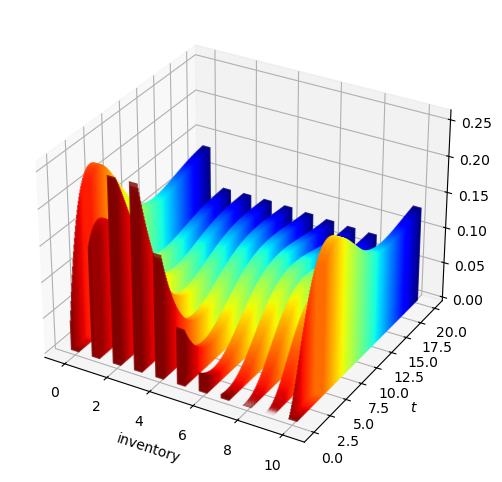](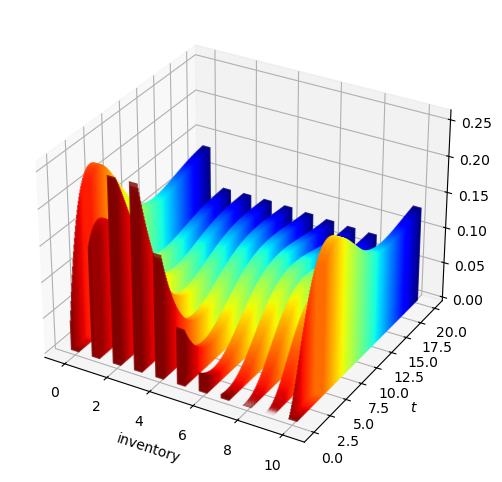)

Probability flows for the inventory model.  
In the (solved) exercises you will be asked to try to reproduce this figure.

## Exercises

## Exercise 3.1

Consider the binary (Bernoulli) distribution where outcomes $ 0 $ and $ 1 $ each have
probability $ 0.5 $.

Construct two different random variables with this distribution.

## Solution to[ Exercise 3.1](https://continuous-time-mcs.quantecon.org/#markov-prop-1)

One example is to take $ U $ to be uniform on $ (0, 1) $ and set $ X=0 $ if $ U <
0.5 $ and $ 1 $ otherwise.

Then $ X $ has the desired distribution.

Alternatively, we could take $ Z $ to be standard normal and set $ X=0 $ if $ Z <
0 $ and $ 1 $ otherwise.

## Exercise 3.2

Show by direct calculation that the Poisson matrices $ (P_t) $ defined in
[(3.9)](#equation-poissemi) satisfy the semigroup property [(3.7)](#equation-chapkol-ct2).

Hints

- Recall that $ P_t(j, k) = 0 $ whenever $ j > k $.  
- Consider using the [binomial formula](https://en.wikipedia.org/wiki/Binomial_theorem).  

## Solution to[ Exercise 3.2](https://continuous-time-mcs.quantecon.org/#markov-prop-2)

Fixing $ s, t \in \RR_+ $ and $ j \leq k $, we have

$$
\begin{aligned}
    \sum_{i \geq 0} P_s(j, i) P_t(i, k)
    & = 
    e^{-\lambda (s+t)} 
    \sum_{j \leq i \leq k}
        \frac{ (\lambda s)^{i-j} }{(i-j)!}  
        \frac{ (\lambda t)^{k-i} }{(k-i)!}  
    \\
    & = 
    e^{-\lambda (s+t)} \lambda^{k-j}
    \sum_{0 \leq \ell \leq k-j}
        \frac{  s^\ell }{\ell!}  
        \frac{ t^{k-j - \ell} }{(k-j - \ell)!}  
    \\
    & = 
    e^{-\lambda (s+t)} \lambda^{k-j}
    \sum_{0 \leq \ell \leq k-j}
        \binom{k-j}{\ell}
        \frac{s^\ell t^{k-j - \ell}}{(k-j)!}  
\end{aligned}
$$

Applying the binomial formula, we can write this as

$$
\sum_{i \geq 0} P_s(j, i) P_t(i, k)
    =
    e^{-\lambda (s+t)} 
    \frac{(\lambda (s + t))^{k-j}}{(k-j)!}
    = P_{s+t}(j, k)
$$

Hence [(3.7)](#equation-chapkol-ct2) holds, and the semigroup property is satisfied.

## Exercise 3.3

Consider the distribution over $ S^{n+1} $ previously shown in [(3.5)](#equation-mathjointd), which is

$$
\mathbf P_\psi^n(x_0, x_1, \ldots, x_n)
    = \psi(x_0)
    P(x_0, x_1)
    \times \cdots \times
    P(x_{n-1}, x_n)
$$

Show that, for any Markov chain $ (X_t) $ satisfying [(3.2)](#equation-markovpropd)
and $ X_0 \sim \psi $, the restriction $ (X_0, \ldots, X_n) $ has joint
distribution $ \mathbf P_\psi^n $.

## Solution to[ Exercise 3.3](https://continuous-time-mcs.quantecon.org/#markov-prop-3)

Let $ (X_t) $ be a Markov chain satisfying [(3.2)](#equation-markovpropd) and $ X_0 \sim \psi $.

When $ n=0 $, we have $ \mathbf P_\psi^n = \mathbf P_\psi^0 = \psi $, and this
agrees with the distribution of the restriction $ (X_0, \ldots, X_n) = (X_0) $.

Now suppose the same is true at arbitrary $ n-1 $, in the sense that
the distribution of $ (X_0, \ldots, X_{n-1}) $ is equal to $ \mathbf P_\psi^{n-1} $ as
defined above.

Then

$$
\PP \{X_0 = x_0, \ldots, X_n = x_n\}
= \PP \{X_n = x_n \,|\, X_0 = x_0, \ldots, X_{n-1} = x_{n-1}  \}
\\
    \times \PP \{X_0 = x_0, \ldots, X_{n-1} = x_{n-1}\}
$$

From the Markov property and the induction hypothesis, the right hand side is

$$
P (x_{n-1}, x_n )
\mathbf P_\psi^{n-1}(x_0, x_1, \ldots, x_{n-1})
=
    P (x_{n-1}, x_n )
    \psi(x_0)
    P(x_0, x_1)
    \times \cdots \times
    P(x_{n-2}, x_{n-1})
$$

The last expression equals $ \mathbf P_\psi^n $, which concludes the proof.

## Exercise 3.4

Try to produce your own version of the figure [Probability flows for the inventory model.](#flow-fig)

The initial condition is `ψ_0 = binom.pmf(states, n, 0.25)` where `n = b + 1`.

## Solution to[ Exercise 3.4](https://continuous-time-mcs.quantecon.org/#markov-prop-4)

Here is one approach.

(The statements involving `glue` are specific to this book and can be deleted
by most readers.  They store the output so it can be displayed elsewhere.)

In [ ]:
α = 0.6
λ = 0.5
b = 10
n = b + 1
states = np.arange(n)
I = np.identity(n)

K = np.zeros((n, n))
K[0, -1] = 1
for i in range(1, n):
    for j in range(0, i):
        if j == 0:
            K[i, j] = (1 - α)**(i-1)
        else:
            K[i, j] = α * (1 - α)**(i-j-1)


def P_t(ψ, t):
    return ψ @ expm(t * λ * (K - I))

def plot_distribution_dynamics(ax, ψ_0, steps=200, step_size=0.1):
    ψ = ψ_0
    t = 0.0
    colors = cm.jet_r(np.linspace(0.0, 1, steps))

    for i in range(steps):
        ax.bar(states, ψ, zs=t, zdir='y', 
            color=colors[i], alpha=0.8, width=0.4)
        ψ = P_t(ψ, t=step_size)
        t += step_size

    ax.set_xlabel('inventory')
    ax.set_ylabel('$t$')


ψ_0 = binom.pmf(states, n, 0.25)
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
plot_distribution_dynamics(ax, ψ_0)

from myst_nb import glue
glue("flow_fig", fig, display=False)
plt.savefig("_static/lecture_specific/markov_prop/flow_fig.png")

plt.show()

<p><a id=footnote1 href=#footnote1-link><strong>[1]</strong></a> On a technical level, right continuity of paths for $ (X_t) $ implies condition 2, as proved in Theorem 2.12 of [[Liggett, 2010](https://continuous-time-mcs.quantecon.org/zreferences.html#id8)].  Right continuity of paths allows for jumps, but insists on only finitely many jumps in any bounded interval.

<p><a id=footnote2 href=#footnote2-link><strong>[2]</strong></a> In the definition of $ P_t $ in [(3.9)](#equation-poissemi), we use the convention that $ 0^0 = 1 $, which leads to $ P_0 = I $ and $ \lim_{t \to 0} P_t(j, k) = I(j,k) $ for all $ j,k $.  These facts, along with the semigroup property, imply that $ (P_t) $ is a valid Markov semigroup.